<a href="https://colab.research.google.com/github/0seoyeon/tobigs-21st/blob/%EA%B3%B5%EC%84%9C%EC%97%B0/Week5/KNN%26Clustering/%EA%B3%B5%EC%84%9C%EC%97%B0/Tobigs_Week5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 21기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current directory:", current_directory) # /content

# 작업 디렉토리 내의 파일 목록 확인
# os.listdir(current_directory)

# 작업 디렉토리 변경
new_directory = os.chdir('/content/drive/MyDrive/Tobigs/regular_session')
current_directory = os.getcwd()
print('Current directory:', current_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/My Drive/Tobigs/regular_session
Current directory: /content/drive/MyDrive/Tobigs/regular_session


In [ ]:
import pandas as pd
df = pd.read_csv("./data/Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

### Exploration

In [ ]:
df.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


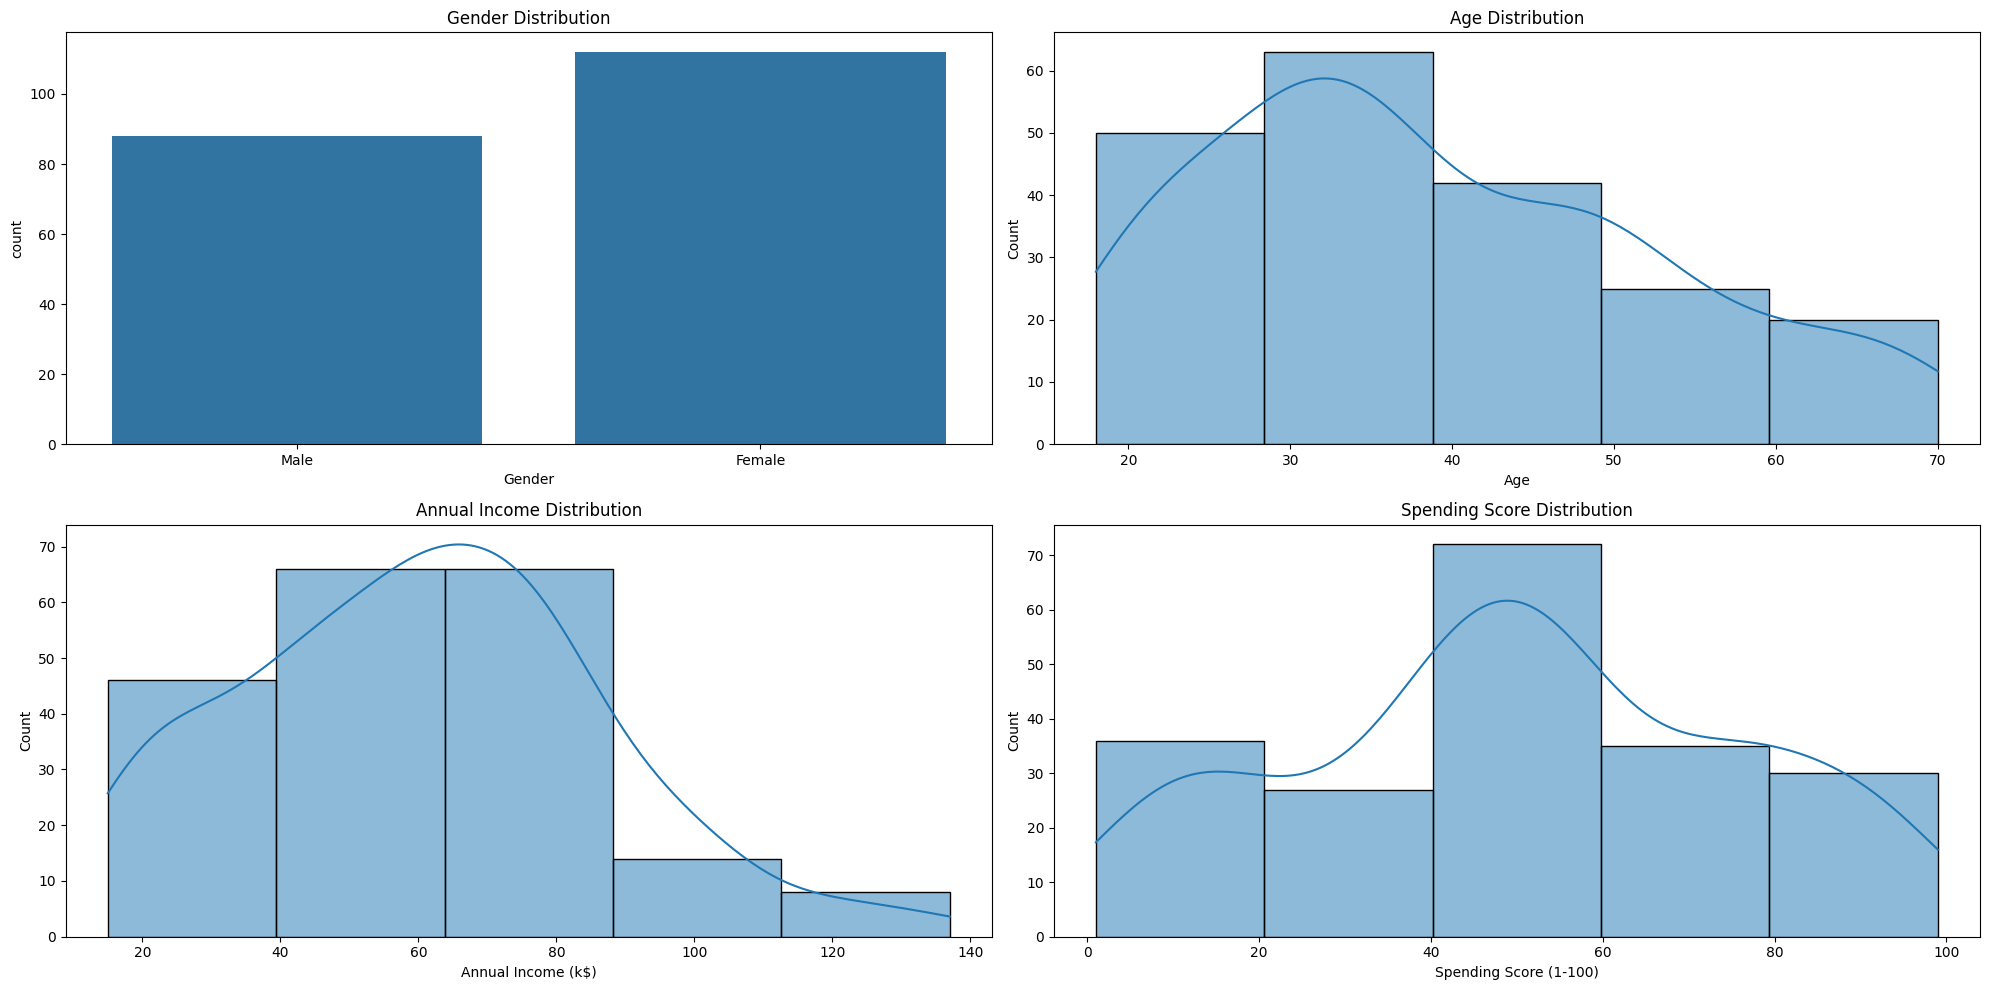

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# gender distribution
sns.countplot(x='Gender', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Gender Distribution')

# age distribution
sns.histplot(df['Age'], bins=5, ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Age Distribution')

# annual income distribution
sns.histplot(df['Annual Income (k$)'], bins=5, ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Annual Income Distribution')

# spending score distribution
sns.histplot(df['Spending Score (1-100)'], bins=5, ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Spending Score Distribution')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Income Distribution by Gender')

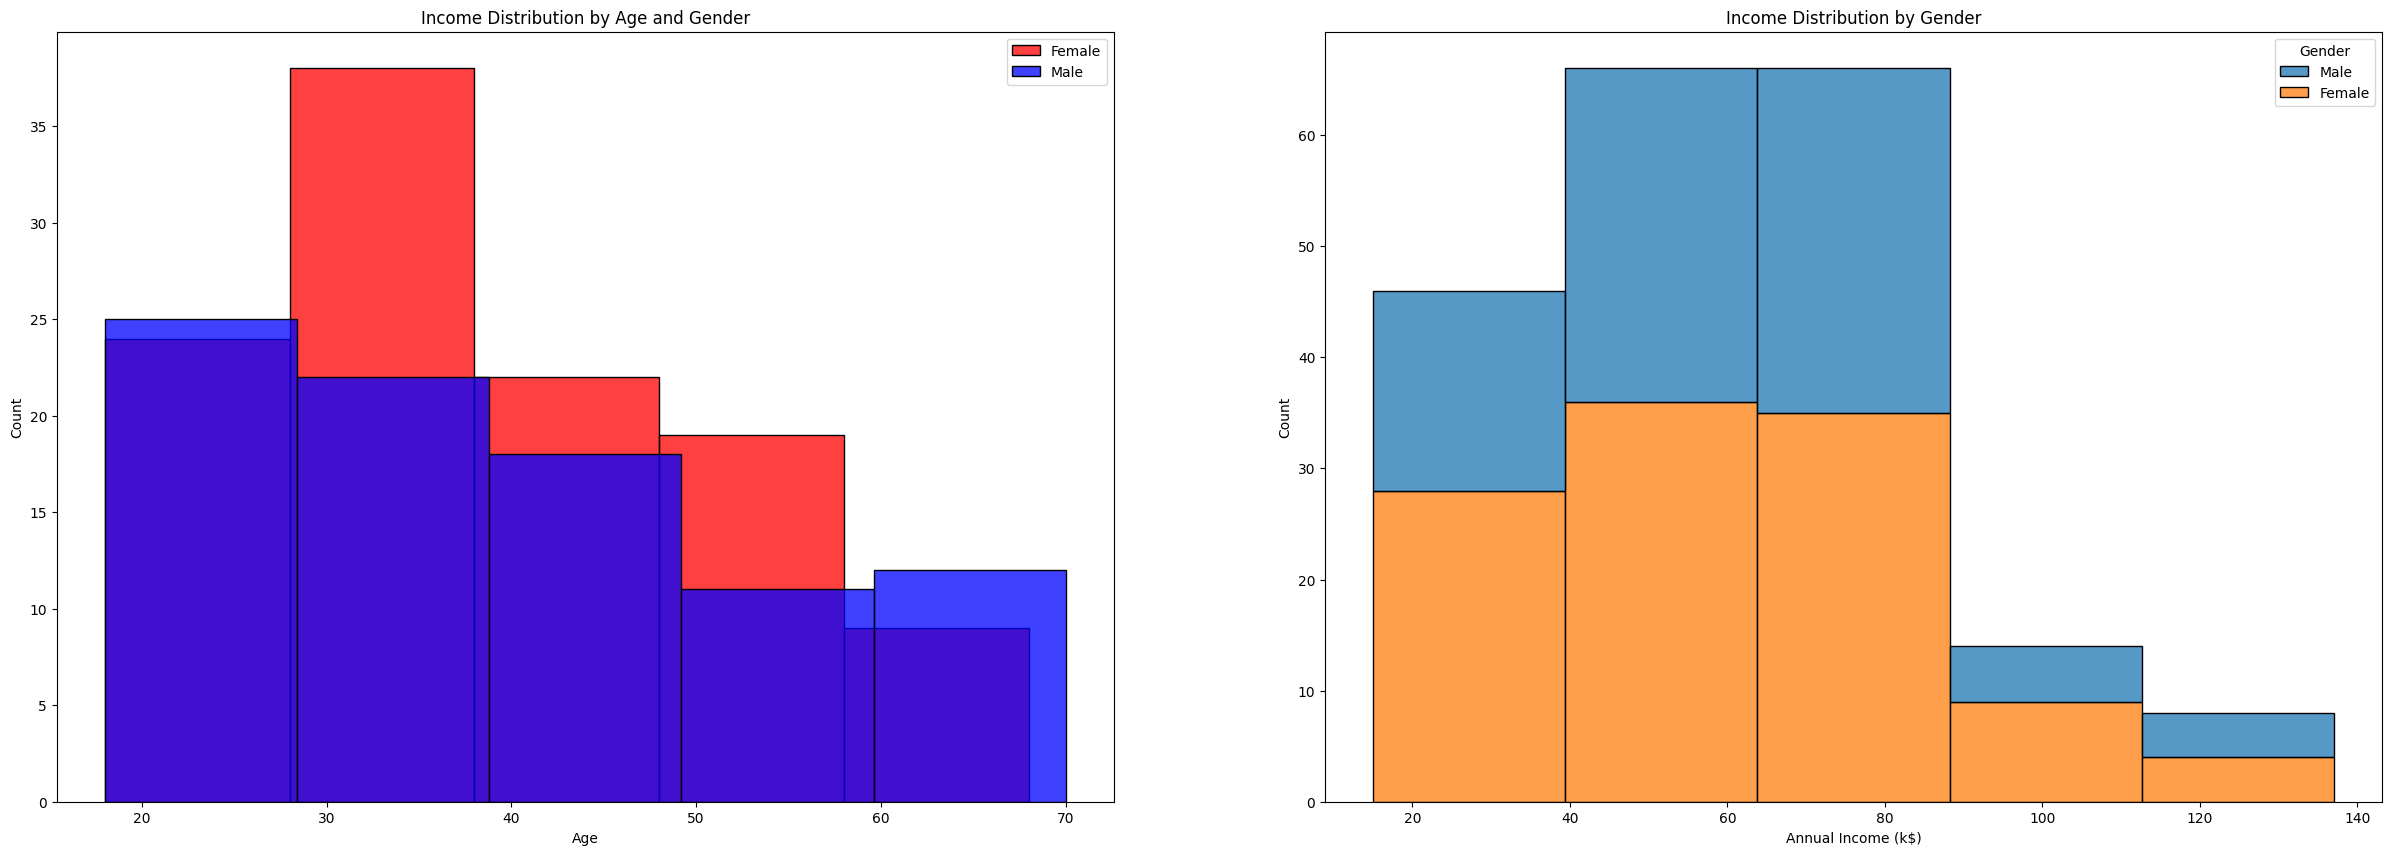

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# income by female
sns.histplot(x='Age', data=df[df['Gender'] == 'Female'], bins=5, color='red', label='Female', ax=axs[0])

# income by male
sns.histplot(x='Age', data=df[df['Gender'] == 'Male'], bins=5, color='blue', label='Male', ax=axs[0])

axs[0].set_title('Income Distribution by Age and Gender')
axs[0].legend()

# income distribution by gender
sns.histplot(x='Annual Income (k$)', data=df, bins=5, hue='Gender', multiple='stack', ax=axs[1])
axs[1].set_title('Income Distribution by Gender')

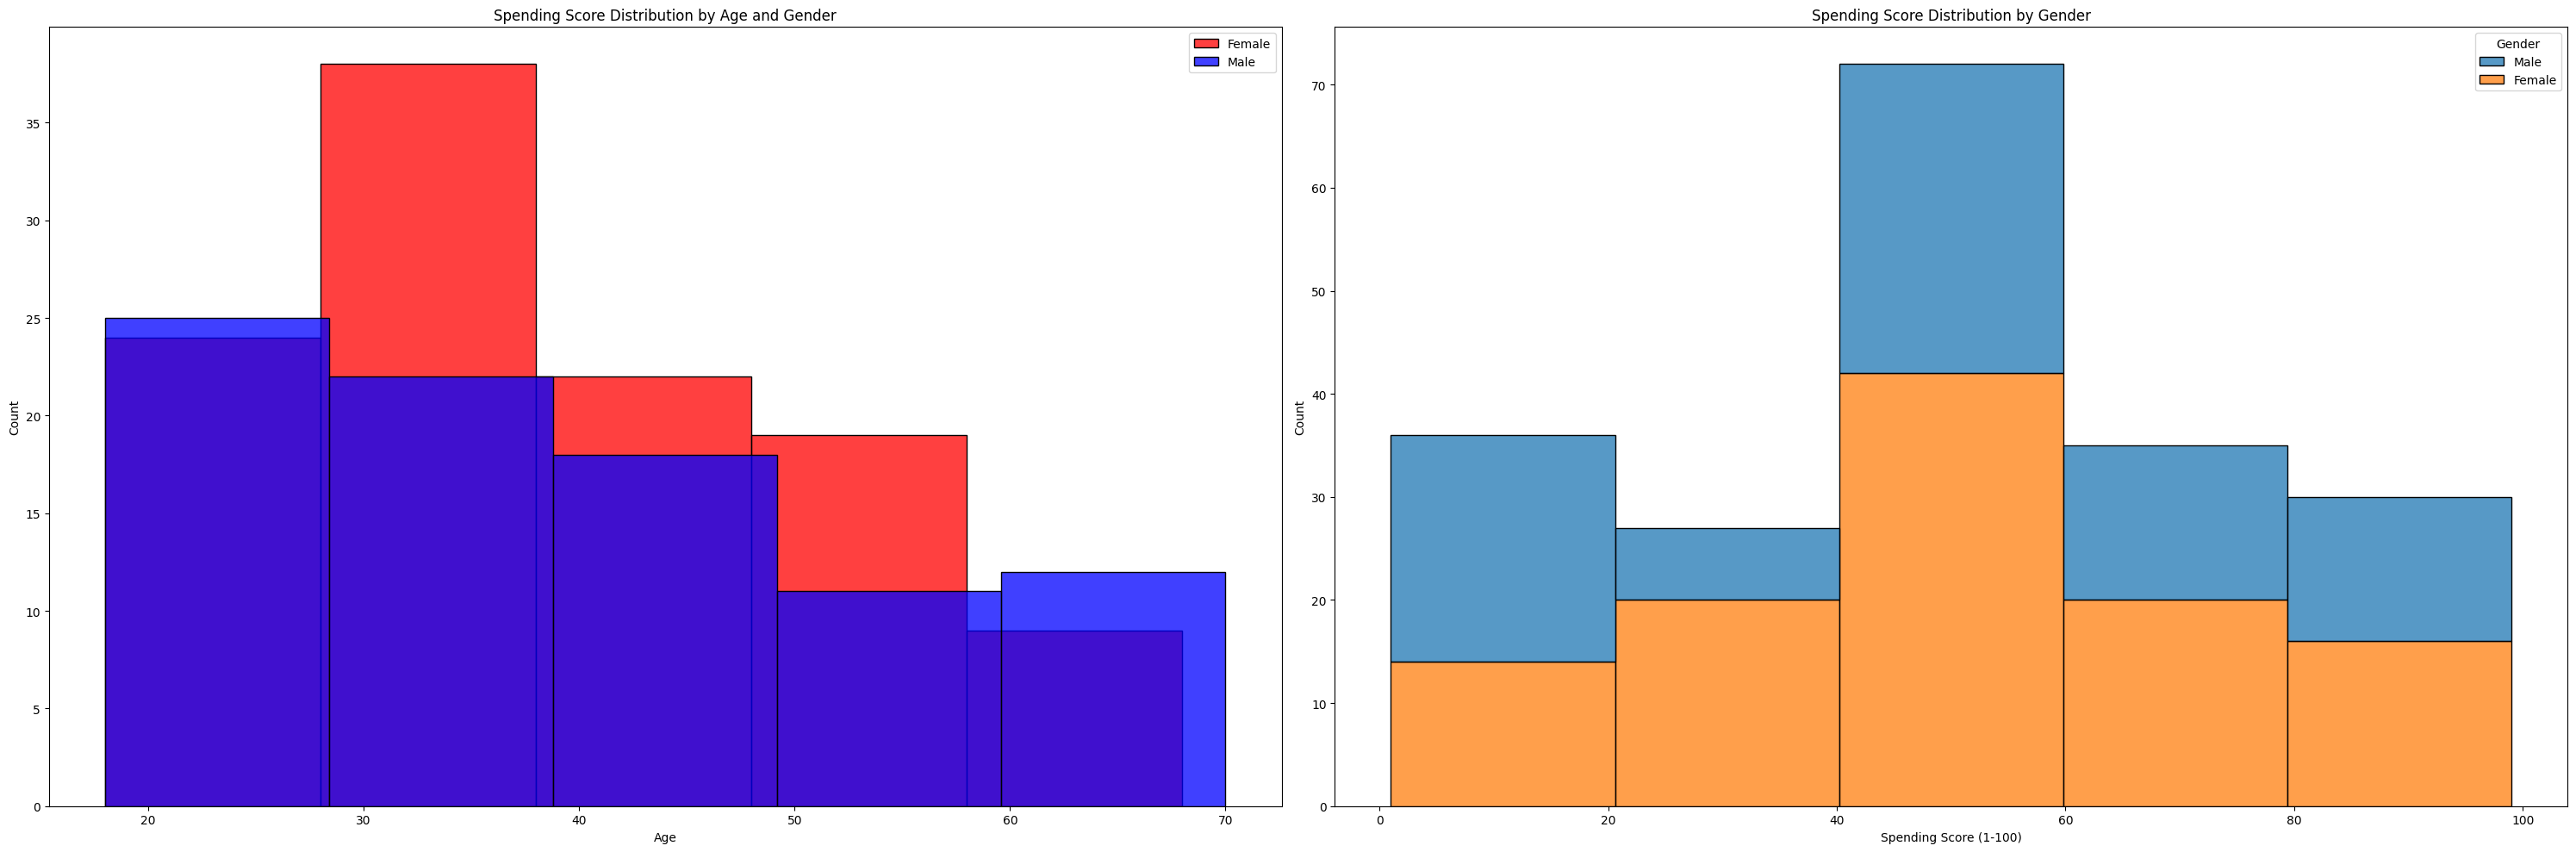

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# spending score by female
sns.histplot(x='Age', data=df[df['Gender'] == 'Female'], bins=5, color='red', label='Female', ax=axs[0])

# spending score by female
sns.histplot(x='Age', data=df[df['Gender'] == 'Male'], bins=5, color='blue', label='Male', ax=axs[0])

axs[0].set_title('Spending Score Distribution by Age and Gender')
axs[0].legend()

# spending score distribution by gender
sns.histplot(x='Spending Score (1-100)', data=df, bins=5, hue='Gender', multiple='stack', ax=axs[1])
axs[1].set_title('Spending Score Distribution by Gender')

plt.tight_layout()
plt.show()

### Scaling & Removing Outliers

In [ ]:
# Distinguish Categorical values and Numerical values
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(exclude='object')
cat_df.columns, num_df.columns

(Index(['Gender'], dtype='object'),
 Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object'))

In [ ]:
def Zscore(data): # normalization
  # z_score 구하기
  mean = np.mean(data, axis=0)
  std = np.std(data)
  z_scores = (data - mean) / std

  return z_scores

df[num_df.columns] = Zscore(num_df)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,0,-1.424569,-1.738999,-0.434801
2,0,-1.281035,-1.738999,1.195704
3,1,-1.352802,-1.700830,-1.715913
4,1,-1.137502,-1.700830,1.040418
5,1,-0.563369,-1.662660,-0.395980


### Label Encoding

In [ ]:
df['Gender'] = pd.factorize(df['Gender'])[0] # factorize는 인수로 시리즈를 받으므로 데이터프레임인 df[cat_df.columns] 실행 시 오류 발생
# check the result
df['Gender'].unique()

array([0, 1])

## 2. Clustering

### Agglomerative Clustering (병합 군집)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

aggcl = AgglomerativeClustering(n_clusters=None, distance_threshold=5).fit(np.array(df))

# check the result
agg_labels = aggcl.labels_
agg_labels

array([5, 2, 5, 2, 5, 2, 5, 2, 7, 2, 7, 2, 7, 2, 5, 2, 5, 2, 3, 2, 5, 2,
       7, 2, 7, 2, 5, 2, 5, 2, 7, 2, 7, 2, 7, 2, 5, 2, 5, 2, 6, 2, 3, 4,
       5, 2, 3, 4, 4, 4, 3, 2, 4, 6, 3, 3, 3, 6, 4, 3, 6, 4, 6, 6, 6, 4,
       3, 6, 4, 4, 6, 3, 6, 6, 6, 4, 3, 3, 4, 3, 6, 3, 6, 3, 4, 3, 6, 4,
       4, 3, 6, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 3, 6, 4, 3, 4, 6, 6, 6, 6,
       6, 4, 4, 4, 4, 4, 6, 3, 3, 3, 4, 4, 4, 1, 4, 1, 3, 1, 0, 1, 0, 1,
       4, 1, 8, 1, 0, 1, 8, 1, 0, 1, 4, 1, 8, 1, 3, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 8, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1])

### Kmeans (비계층적 군집화)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(np.array(df))
kmeans_labels = kmeans.labels_
print(f'labels: {kmeans_labels}')

labels: [9 8 9 8 9 8 9 8 5 8 5 8 5 8 9 8 9 8 5 8 9 8 5 8 5 8 9 8 9 8 5 8 5 8 5 8 9
 8 9 8 2 8 3 7 6 7 6 7 7 7 6 7 7 2 6 3 6 2 7 3 2 1 2 6 2 1 6 2 1 7 2 6 2 2
 2 1 6 3 7 6 2 3 2 6 7 3 6 7 7 6 2 1 3 6 7 1 6 7 3 1 1 6 2 1 3 1 2 3 2 2 2
 1 6 1 1 1 2 6 6 6 1 6 6 4 1 4 3 4 0 4 0 4 1 4 1 4 0 4 1 4 0 4 1 4 1 4 3 4
 0 4 0 4 0 4 0 4 0 4 0 4 6 4 1 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0
 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4]


## 3. Evaluation

In [ ]:
from sklearn import metrics

agg_silhouette_avg = metrics.silhouette_score(df, agg_labels)
print("agglomerative_silhouette_score:", agg_silhouette_avg)

km_silhouette_avg = metrics.silhouette_score(df, kmeans_labels)
print("kemans_silhouette_score:", km_silhouette_avg)

# 0.5 미만이기에 군집 결과가 타당하다고 볼 수 없다.

agglomerative_silhouette_score: 0.32325945194345374
kemans_silhouette_score: 0.31218345498061195


두 방법 모두 성능이 매우 낮다.